## Introdução <a id='introduction'></a>

Métodos de otimização contínua buscam um minimizador local de uma função suave
$$f: \mathbb{R}^n \to \mathbb{R}.$$
Em geral, $f$ é duas vezes continuamente diferenciável (mesmo se as derivadas não estiverem disponíveis ou seu cálculo seja inviável computacionalmente)

Vamos falar sobre o método do Gradiente, ou Método de Cauchy. Assim, dado um ponto inicial $x^0\in \mathbb{R}^n$, procuramos gerar uma sequência de pontos $x^k\in \mathbb{R}^n$ tal que cada nova iteração é dada por 
$$x_{k+1} = x_k + \alpha_k p_k$$
em que $p_k$ é uma *direção de descida*, ou seja, é uma direção na qual sabemos que a função objetivo tem seu valor reduzido (ao menos localmente). Então, $p_k$ deve satisfazer a condição
$$p_k^T\nabla f(x_k) < 0.$$
Em geral, $\| p_k\|_2=1$, e assim $\alpha_k$ determina o tamanho do passo que será tomado nessa direção. 

Repetiremos essa iteração até que seja encontrado um ponto para o qual $\nabla f(x_k)=0$ ou $|\nabla f(x_k)|<\epsilon$, em que $\epsilon >0$ é alguma tolerância (em geral, algo em torno de $10^{-10}$, por exemplo).

### Função de teste

A <a href="https://en.wikipedia.org/wiki/Rosenbrock_function">função de Rosenbrock</a> é uma função conhecida para se testar algoritmos de otimização irrestrita. A forma usual é 
$$f(x) = (1-x_0)^2 + \beta(x_1-x_0^2)^2$$
em que $\beta$ é algum número real (normalmente positivo). Vamos usar $\beta=10$:

In [1]:
def rosenbrock(x):
    return (1-x[0])**2+10*(x[1]-x[0]**2)**2

Agora, podemos calcular o valor da função de Rosenbrock em um determinado ponto:

In [3]:
x = [-1,2]

ao fazermos

In [4]:
rosenbrock(x)

14

### Método do gradiente

Conforme já discutido em aula, vamos usar aqui $p_k = -\nabla f(x_k)$ em todas as iterações. Para isso, vamos definir uma função que calcula o gradiente da função:

In [5]:
import numpy as np

In [6]:
def gradiente(x):
    return np.asarray([2*x[0]-2-40*x[0]*(x[1]-x[0]**2), 20*(x[1]-x[0]**2)])

(observe que definimos a saída da função gradiente como uma ndarray, pois isso será necessário mais à frente)

Então, escolha um ponto inicial:

In [8]:
x = [-1,2]

A direção aqui será

In [9]:
p = -gradiente(x)

Nessa direção, se tomarmos um passo com $\alpha^k=1$, teremos:

In [10]:
ponto_inicial = np.asarray(x)
ponto_novo = ponto_inicial + p

Assim

In [11]:
ponto_novo

array([-37, -18])

Vamos ver na figura:

In [12]:
import matplotlib.pyplot as plt

In [13]:
def grafico_curvas(points):
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    R = rosenbrock([X, Y])
    plt.figure()
    levels = [0, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 50, 100]
    plt.contour(X, Y, R, levels)

    for point in points:
        plt.plot(point[0], point[1], 'ro')

Text(-37.2, -18.3, 'x_1')

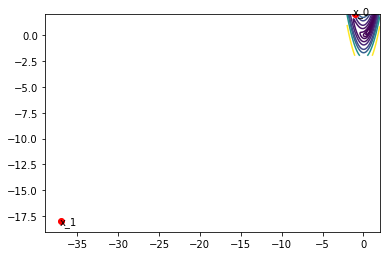

In [14]:
grafico_curvas((ponto_inicial, ponto_novo))
plt.annotate("x_0", ponto_inicial, xytext=ponto_inicial-np.asarray([0.3, 0]))
plt.annotate("x_1", ponto_novo, xytext=ponto_novo-np.asarray([0.2, 0.3]))

No entanto, um passo nessa direção na verdade *aumentou* o valor da função:

In [15]:
rosenbrock(ponto_inicial)

14

In [16]:
rosenbrock(ponto_novo)

19239134

## Backtracking

Já vimos em aula que as condições de Wolfe garantem que poderemos encontrar um $alpha_k$ apropriado que (i) resulta em um *decréscimo suficiente* no valor da função objetivo; e (ii) satisfaz a condição de curvatura. No entanto, encontrar esse ponto diretamente pode ser difícil. 

Propomos então a estratégia seguinte: vamos escolher o maior valor de $\alpha$ tal que $x_k+\alpha p_k$ satisfaça a condição de decréscimo suficiente. (vamos criar uma função para esse procedimento para podermos utilizá-la novamente mais tarde):

In [17]:
def buscalinear(ponto_inicial, p, c1=1e-4):
    alpha = 1 # A escolha do alpha inicial também pode ser discutida, 
              # mas aqui escolheremos simplesmente alpha=1.
    f_inicial = rosenbrock(ponto_inicial)
    grad_inicial = gradiente(ponto_inicial)
    ponto_novo = ponto_inicial + alpha*p
    while rosenbrock(ponto_novo) > f_inicial + c1*alpha*np.dot(grad_inicial, p):
        alpha = 0.9*alpha
        ponto_novo = ponto_inicial + alpha*p
    return ponto_novo

In [18]:
ponto_novo = buscalinear(ponto_inicial, p)

In [19]:
ponto_novo

array([-1.53211179,  1.70438234])

Na figura:

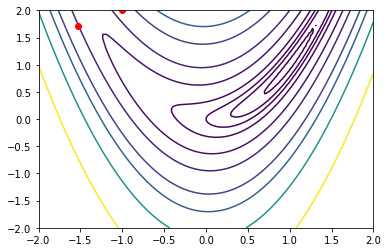

In [20]:
grafico_curvas((ponto_inicial, ponto_novo))

Agora sim:

In [21]:
rosenbrock(ponto_novo)

10.545876695949666

Vamos repetir o processo até que estejamos satisfeitos com o valor do gradiente da função. 

In [22]:
def metodo_do_gradiente(fun, grad, x, tolerancia_gradiente):
    p = -grad(x)
    while np.sqrt(p[0]**2+p[1]**2) > tolerancia_gradiente:
        x = buscalinear(x, p)
        p = -grad(x)
    return x

In [23]:
solucao = metodo_do_gradiente(rosenbrock, gradiente, ponto_inicial, 1e-3)

De fato,

In [24]:
gradiente(solucao)

array([ 0.00093914, -0.00024748])

Finalmente, podemos modificar nosso método do gradiente para guardarmos todas as iteradas e observarmos o caminho do método do gradiente:

In [25]:
def metodo_do_gradiente(fun, grad, x, tolerancia_gradiente):
    iteradas = []
    # iteradas é uma lista que guarda todos os pontos gerados pelo método
    iteradas.append(x)
    p = -grad(x)
    while np.sqrt(p[0]**2+p[1]**2) > tolerancia_gradiente:
        x = buscalinear(x, p)
        iteradas.append(x)
        p = -grad(x)
    return x, iteradas

In [26]:
solucao, iteradas = metodo_do_gradiente(rosenbrock, gradiente, ponto_inicial, 1e-3)

In [27]:
iteradas

[array([-1,  2]),
 array([-1.53211179,  1.70438234]),
 array([1.66032094, 2.62757644]),
 array([1.58260333, 2.64785678]),
 array([1.65156674, 2.6228558 ]),
 array([1.58693743, 2.63932288]),
 array([1.64370311, 2.6182095 ]),
 array([1.59043967, 2.63133555]),
 array([1.63667831, 2.61355892]),
 array([1.59316856, 2.6237953 ]),
 array([1.63043051, 2.60885141]),
 array([1.59519224, 2.61662053]),
 array([1.62489032, 2.60405536]),
 array([1.59343928, 2.61037671]),
 array([1.62275994, 2.59792575]),
 array([1.59182009, 2.60410935]),
 array([1.62051193, 2.59185212]),
 array([1.5903278 , 2.59782323]),
 array([1.6181555 , 2.58583438]),
 array([1.58895241, 2.59152376]),
 array([1.61570233, 2.57987123]),
 array([1.58768123, 2.58521673]),
 array([1.61316606, 2.57396026]),
 array([1.58649946, 2.57890805]),
 array([1.61056175, 2.56809803]),
 array([1.58539083, 2.5726036 ]),
 array([1.60790538, 2.56228025]),
 array([1.58433818, 2.56630899]),
 array([1.60521324, 2.55650198]),
 array([1.58332417, 2.560029

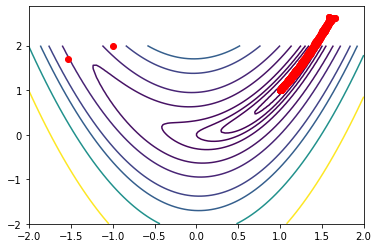

In [28]:
grafico_curvas(iteradas)

Ok! Achamos uma solução. Mas o método não é muito bom: levamos

In [29]:
len(iteradas)

1401

para encontrarmos a solução...